### 1. Supervised Machine Learning: 
    
A dataset $A$ with $m$ instances $\textbf{x}_{1}, \textbf{x}_{2}, ..., \textbf{x}_{m}$, where each instance $\textbf{x}_{i}$ is defined by an $n$  features as
$\textbf {x}_{i}=(x_{i1}, x_{i2}, ..., x_{in})$. 


Learn a function **${h(x)}$** that maps an instance $x_i \in A$ to a class$y_j\in Y$.

$$
\left(\begin{array}{cc} 
x_{11} & x_{12} & \dots & x_{1p} \\
    x_{21} & x_{22} & \dots & x_{2p} \\
    \vdots & \vdots & \ddots & \vdots\\
    x_{m1} & \vdots & \dots & x_{mp} \\
\end{array}\right)
\left(\begin{array}{cc} 
y_{1}\\
..\\
..\\
..\\
y_{n}
\end{array}\right)
$$ 

One way to improve the learning processs is by applying class-decomposition to the dataset before applying Machine Leanring. Class decomposition describes the process of segmenting each class into a number of homogeneous subclasses. This is achieved through clustering. Utilising class decomposition can provide a number of benefits to supervised learning, especially ensembles. It can be a computationally efficient way to provide a **linearly separable data set** without the need for feature engineering required by techniques like support vector machines and deep learning. Medical data for patient diagnosis may greatly benefit from this technique, as the same disease can have a diverse of symptoms. 


#### Class Decomposition 

With class decomposition (CD), we can tranform the above dataset into the following form: 

$$
\left(\begin{array}{cc} 
x_{11} & x_{12} & \dots & x_{1p} \\
    x_{21} & x_{22} & \dots & x_{2p} \\
    \vdots & \vdots & \ddots & \vdots\\
    x_{m1} & \vdots & \dots & x_{mp} \\
\end{array}\right)
\left(\begin{array}{cc} 
y_{1_{c1}}\\
y_{1_{c2}}\\
..\\
..\\
y_{n_{ck}}
\end{array}\right)
$$ 

For further illustration, lets consider a binary classification problem (i.e. $X$ in Equation below and suppose that $X$ contains 100 observation with a label set $Y \in \{a,b\}$, and suppose that we decomposed its first class label into two subclasses, and the $2^{nd}$ class label into 3 subclasses. In addition, let's assume that a machine learning algorithm $\phi$ is applied which resulted in a classifier $h_{c}$ with a 100\% accuracy represented in the form of a confusion matrix as can be seen below.




\begin{equation}\label{eq4}
h_{c}=\begin{bmatrix}
 &  a_1&  a_2 & b_1 &b_2 & b_3\\ 
  a_1&  \textbf{10}&  \textbf{5} & 0 &0 & 0\\ 
  a_2&  \textbf{4}&  \textbf{31} & 0 &0& 0\\ 
  b_1&  0&  0 & \textbf{8} &\textbf{6}& \textbf{10}\\ 
  b_2&  0&  0 & \textbf{9} &\textbf{1}& \textbf{16}\\ 
  b_3&  0&  0 & \textbf{2} &\textbf{17} &\textbf{7}
\end{bmatrix}
\end{equation}

Notice that, the confusion matrix shown above is often used to compute the accuracy of a classifier by summing all elements at the diagonal and dividing it by the total number of observations (i.e. $\frac{\sum_{i=1}^{n} h_{ii}}{M}$). However, the accuracy of $h_{c}$ denoted by $Accuracy(h_c)$is computed in a slightly different way to account for the decomposition of the classes in the data set:


\begin{equation}\label{eq5}
Accuracy(h) = \frac{\sum_{i=0}^{nClasses}\sum_{j=0}^{k_i}h_c(i,j+ [k_{i-1}*i])}{m}
\end{equation}


Where $m$ is the number of observations (i.e. 100), and $nClasses$ represents the number of discrete classes in the data set, while $k_i$ represents the number of clusters applied to each class as will be discussed in the next section. In short, the Equation above will result in summing all the \textbf{bold} elements of the confusion matrix.


#### Implementation 

Below is a set of functions for implementing CD and apply it along with a Random Forest classifier to show its impact on RF performance. First, the function **clustSet** does the followings: 

* Prepare  dataset by clustering 
* The function will take a dataframe (df), number of clusters(k)
* and an index (ClassIndex) for the label and would return 
* a dataframe of the clustered labels

In [1]:
clustSet <- function (df, k=3,ClassIndex) {
    
    # use split function to split the dataset according to the class label
    # a set of dataframes each representing a class lable will be stored
    # in dfs list()
    require(plyr)        
    dfs <- split (df, df[,ClassIndex])
    #cat("splitted ", length(dfs),"\n")
    clustList <- list()  
    n <- length(dfs)
    for (i in 1:n){
        # Cluster according to all features excluding the label 
        clustList[[i]] <- kmeans(dfs[[i]][,-ClassIndex],k)
        # assign the cluster values to the training set
        
        #dfs[[i]]$cluster <- paste0("c",clustList[[i]]$cluster,"_",
        #                           (dfs[[i]][,ClassIndex]))
        
        dfs[[i]]$cluster <- paste0((dfs[[i]][,ClassIndex]),
                                   "_","c",clustList[[i]]$cluster)

    }
    # put all list elements in a dataframe and return it
    allClusteredElements <- ldply (dfs, data.frame)
    # drop the first column 'id' resulting from ldply
    allClusteredElements <- allClusteredElements[,-1]
    
    allClusteredElements <- allClusteredElements[,-ClassIndex]
            
    return(allClusteredElements)
}


#### How it Works 

Here is a set of functions that can be applied along the **clustSet** Function for Machine Learning. 

Several datasets needs to be normalized before applying some techniques (e.g. kmeans) which depends on distance calculations and sensetive to noise. 

In [2]:
# Normalize data 
normalizeData <- function (x ) {
    
    return ( (x-min(x) ) / ( max(x)- min(x) ))
}

* Another generic function to fit Random Forest: 


In [3]:
fitRFU <- function (nTreeStart = 100, nTreeEnd=1000, nTreeBy=100,
                   trainSet=subTrain, testSet=subTest, lIndex=1, clustC=FALSE){
    
    set.seed(1111)
    # try different ntree values 
    nTrees <- seq(nTreeStart,nTreeEnd, by =nTreeBy)
    nts <- length(nTrees)
    oobErr <- c(nts); 
    testErr <- c(nts); 
    oobErr1 <- c(nts); # check different ways for computing error
    testErr1 <- c(nts); 
    predDF <- data.frame(0,0)
    predDFNC <- data.frame(0,0)
    for (i in 1:nts){
        
        
        labels <- as.factor(trainSet[,lIndex])
        train <- trainSet[,-lIndex] 
                             
        clustRF <- randomForest(train, labels, xtest=testSet[,-lIndex], 
                                    ytest=factor(testSet[,lIndex]), 
                                ntree=nTrees[i], 
                                    proximity=TRUE, importance = TRUE, 
                                    keep.forest=TRUE)
        

        oobErr[i] <- clustRF$err.rate[nTrees[i]]
        
        predictions <- levels(labels)[clustRF$test$predicted]
        
        if (clustC!=TRUE){
                        
            testErr1[i] <- (sum(predictions ==testSet[,lIndex])/nrow(testSet))*100
            predDFNC <- data.frame(predictions, testSet[,lIndex])
            # the above testErr will only apply to nonclustered approach
        }
        
        else {
                
            predDF <- data.frame(predictions, testSet[,lIndex])
            predDF$label <- factor(predDF[,2])
            
            predDF <- predDF[,-2]
            predDF$correctClass <- ifelse(substr(predDF$predictions,1,
                          nchar(as.character(predDF$predictions))-3)==
                          substr(predDF$label,1,
                                 nchar(as.character(predDF$label))-3),1,0)
            
            testErr1[i] <- (sum(predDF$correctClass==1)/ nrow(testSet))*100
            
        } 
    }
    # copy error values into a data frame and return it
    errDF <- cbind(testErr1,c(1:nts))
    # return data frame of errors 
    list(errDF,clustRF,predDF,predDFNC)
}

* Utility function to show the results (compare ML with CD and without CD), the function takes:

* A df (data frame), setSize(training size), iterations(n iterations),
* k (n clusters), kInc (increment k by), treeSeq (a vector contains
* the starting number of trees, stop number and increment by)


In [4]:
visResults <- function (df, setSize,testSet, incSize, iterations,k,
                        kInc,treeSeq,mfrowS){
    
    nplots <- round (iterations/2,0)
    treeParams <- seq(treeSeq[1],treeSeq[2],treeSeq[3])
    par(mfrow=mfrowS)
    cIndex <- 3 

    for (i in 1:iterations){
        xlabel <- paste0("Number of Trees (K=",k, ", Training Size=", setSize ,
                         ", Testing Size=",testSet,") ")
        matplot(1:length(treeParams), cbind(df[,cIndex],df[,2]), 
                pch=c(19,23), col=c('blue','red'),
            xaxt='n', type=c('b','b'),lty=1, ylab="Classification Accuracy %", 
            xlab= xlabel, frame=FALSE)
        axis(1, at = 1:length(treeParams), labels = treeParams, cex.axis = 0.7)
        legend("topright", legend=c("RFC","RF"), pch=c(19,23), col=c('blue','red')
          ,bty="n" ,yjust=2,pt.cex=1)
        # Each iteration the sample size is increase by 50
        k <- k + kInc; setSize <- setSize + incSize;
        cIndex <- cIndex + 1 
    }
}

Now, we want to partition to the datset into training, and testing subsets. The function \textbf{divideTT} takes a dataframe (e.g. the dataset), class label index, the the propotion of partitioning as input paramters and return a list contains two dataframes (traning and testing) respectively. 


In [5]:
divideTT <- function (df, labelIndex=1,pVal=0.75) {
    
    require(caret)
    #set.seed(3456)
    trainIndex <- createDataPartition(df[,labelIndex], p = pVal,
                                          list = FALSE,
                                          times = 1)
    training <- df[ trainIndex,]
    testing  <- df[-trainIndex,]
    
    # for global assignment uncomment 
#     assign("train", training, envir = .GlobalEnv)
#     assign("test", testing, envir = .GlobalEnv)
    listSet <- list(training,testing)
    return (listSet)
}    


Here, we will call the above functions to load, cluster and classify the hand written digits. First, lets build the main function 


In [6]:
fitCRFModel <- function (pValue, dfWN=NULL, trainDF=NULL,testDF=NULL,iterations, 
                       kVal=3, incK=2,nTreeStart = 100, nTreeEnd=1000,
                       nTreeBy=100,lIndex=1){

    minErr <- 10000 #Keep best RF
    bestRF <- NULL
    bestK <- kVal 

    predDF <- data.frame(0,0)
    if (!is.null(dfWN)){
            
        listR <- divideTT(dfWN, lIndex, pValue) 
        nrow(listR[[1]]); nrow(listR[[2]]); 
        table(listR[[1]][lIndex]); table(listR[[2]][lIndex])
        # assign the list of elements to training, testing sets
        trainDF <- listR[[1]]; testDF <- listR[[2]]
    }
    

    require(randomForest); require(RColorBrewer);
    # This to be put in a for loop 
    k <- kVal ; # number of clusters 
    # dataframe to hold results 
    results <- data.frame("no"= length(seq(nTreeStart, nTreeEnd,nTreeBy)))
    cIndex <- 2 #column index 
    for (i in 1:iterations) {
        
        # cluster the trainingset
        trainC <- clustSet(trainDF, k, lIndex)
        
        testC <- clustSet(testDF,k,lIndex)

        if (i==1){
            df <- fitRFU(nTreeStart, nTreeEnd, nTreeBy, trainDF, testDF,lIndex,FALSE)
            cName <- paste0("RF","_Inst",nrow(trainDF))
            results <- cbind(results, "x"=df[[1]][,1])
            names(results)[cIndex] <- cName
            cIndex <- cIndex + 1
        }
        cdf<- fitRFU(nTreeStart, nTreeEnd, nTreeBy, trainC, testC,ncol(trainC),TRUE) 

        cName <- paste0("K",k,"_Inst")
        results <- cbind(results, "x"=cdf[[1]][,1])
        #write.csv(trainC,"trainC.cs")
        errVal <-  100 - min(cdf[[1]][,1])
        if (errVal < minErr) {
            bestRF <- cdf[[2]]

            predDF <- cdf[[3]]
            bestK <- k
            
        }
        names(results)[cIndex] <- cName
        cIndex <- cIndex + 1
        # update results 
        
        k <- k+incK 
        
    }
#           1           2           3           4       5   6      
    list(results, nrow(trainDF),nrow(testDF), bestRF,bestK,predDF) 
}

#### Example (Diabetes Dataset)

From National Institute of Diabetes and Digestive and Kidney Diseases; Includes cost data (donated by Peter Turney). More information available at  [https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes]

* **Load** the dataset


In [7]:
diabetes <- read.table("data/diabetes_pima_indians.txt",
                       sep=',',head=FALSE,na="?")
cat("Number of Rows in the Dataset is: ", nrow(diabetes),"\n")
cat("Number of Columns: ", ncol(diabetes),"\n") 
names(diabetes)[9] <- "label" #label either test postive or negative
table(diabetes$label)

Number of Rows in the Dataset is:  768 
Number of Columns:  9 



  0   1 
500 268 

* Check missing values and
* **Normalise the Data** 



In [8]:
x <- sapply(diabetes, function(x) sum(is.na(x)))
cat ("Total Number of Missing Values: ", sum(x),"\n")


Total Number of Missing Values:  0 


In [9]:
diabetesN <- as.data.frame(lapply(diabetes[,-9], normalizeData) )
diabetesN$label <-  diabetes$label

* **Set values** and run the Experiment:


In [13]:
# split ratio
pValue <- 0.66  ; iterations <- 6;
mfrow <-c(3,2);
# start with k = 2
kVal <- 2 ; incK <- 1 ;nTreeStart <- 100 ;
nTreeEnd <- 1000 ; nTreeBy <- 100;
lIndex = 9

listR <- divideTT(diabetesN, lIndex, pValue)
        # assign the list of elements to training, testing sets
        trainDF <- listR[[1]]; testDF <- listR[[2]]


results <- fitCRFModel (pValue,NULL, trainDF, testDF, iterations, kVal,
                       incK,nTreeStart, nTreeEnd,nTreeBy,lIndex)

* Extact and save results for visualisations and comparisons: 


In [15]:
dataset <- "Diabetes"
nrowTrain <- results[[2]]; nrowTest <- results[[3]];
nCols<- ncol(diabetesN); nClass <-2; bestK<- results[[5]]
cRF<-round(max(results[[1]][,3:ncol(results[[1]])]),2)
RF <- round(max(results[[1]][,2]),2)
winLose<- ifelse( cRF >RF,"Win",ifelse(cRF==RF,"Tie","Lose"))

* Show results 

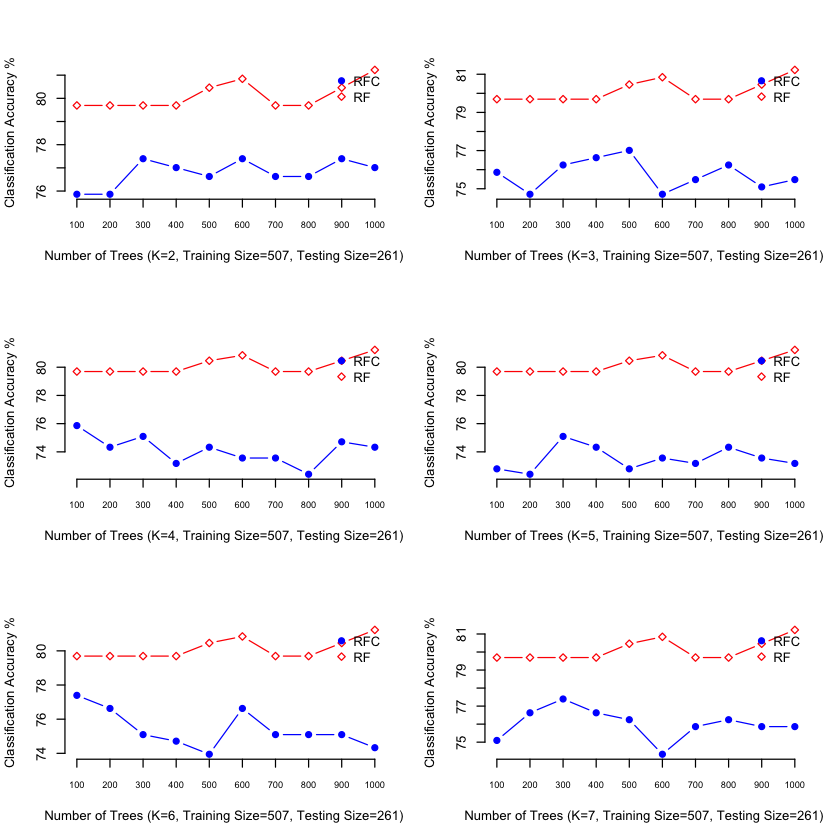

In [16]:
treeParams <- c(100,1000,100)
visResults(results[[1]], results[[2]],results[[3]],0, iterations,kVal,
               incK,treeParams,mfrow)

### Results and To-Do List
Overall,  you can see that Random Forest with Class Decomposition (RFC) outperforms Random Forest without CD (RF). However, there is few things to fix in the above code: 

* The data was split into train / testing sets, but this could lead to a risk of over fitting, so you need to split the data into train, validate and test set, and hold out the testing set for the final stage and use it only when evaluating the best RFC model

* The **k** value here wasn’t optimised, but was found experimentally. Think how can the best k value be set to optimise RF performance? 


* CD can be applied to handle class-imbalance, for example in a largely imbalanced dataset, the majority class instances can be decomposed into subclasses to reduce its dominance over the learning space. This also ensures that no information loss will be caused as it is often  the case when applying undersampling. Below is a slightly modified function, that can apply decomposition to a particular class. The function does similar job as the above one: 
